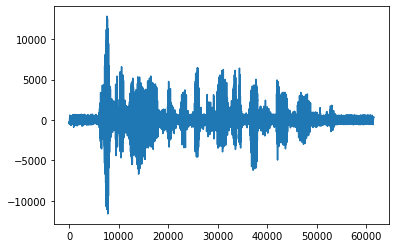

[-417 -430 -424 ...  378  373  372]


In [50]:
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt
import numpy as np

#считали звуковой файл
sr, data = wavfile.read("Mono16kHz.wav")
freq = 16000
#смотрим на наш сигнал
plt.plot(data)
plt.xlabel("Изначальный сигнал")
plt.show()


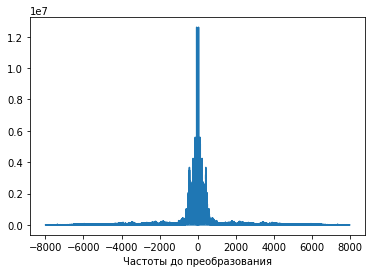

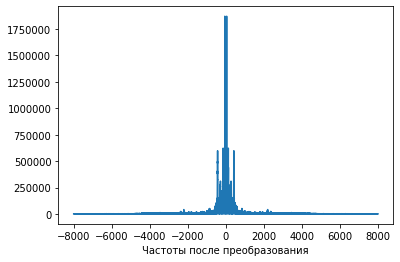

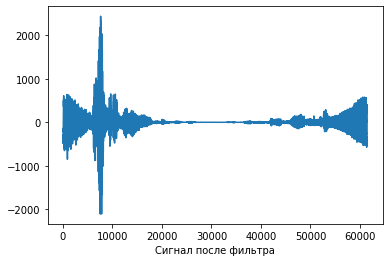

D:\miniconda3\lib\site-packages\ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


In [54]:
#!!!!!!! Filter of low frequency !!!!!!!
yf = fft(data)#прямое одномерное ДПФ.
xf = fftfreq(len(data), 1 / freq)#перевод оси x-ов в частотную
#смотрим на частотный спектр нашего сигнала

plt.plot(xf, np.abs(yf))#np.abs() вычисляет корень суммы квадратов реальной и мнимой части
plt.xlabel("Частоты до преобразования")
plt.show()
#применяем фильтр нижних частот
#wn = 2 * 1000 / freq = 0.125
b, a = signal.butter(1, 0.125, "lowpass")#готовим b и a для наложения фильтра нижних частот
filtedData = signal.filtfilt(b, a, yf)#отсеиваем все что больше 1кГц

print()
plt.plot(xf, np.abs(filtedData))#смотрим что верхние частоты в самом деле ушли
plt.xlabel("Частоты после преобразования")
plt.show()

filtered = ifft(filtedData)#обратное фурье (правда на выходе все еще комплексное число)

plt.plot(filtered.real)#смотрим на преобразившийся сигнал. середина записи угашена
plt.xlabel("Сигнал после фильтра")
plt.show()

norm_new_sig = np.int16(filtered * (32767 / filtered.max()))#без нормировки на записи получается скример
wavfile.write("LowFilteredMono16kHz.wav", freq, norm_new_sig)#записали чтобы послушать

[23880, 1194, 597, 298, 149, 74, 37, 18, 9, 4]
[0.6, 0.42, 0.294, 0.20579999999999998, 0.14405999999999997, 0.10084199999999997, 0.07058939999999998, 0.049412579999999984, 0.034588805999999986, 0.02421216419999999]
87746


D:\miniconda3\lib\site-packages\ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


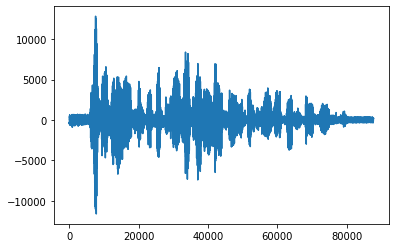

In [84]:
#!!!!! Echo segment !!!!!!!

#Сначала фильтруем сумму сигналов с помощью ФНЧ первого порядка, потом прибавляем к изначальному. 
#D1 - задержка, задается пользователем
#Di=D1*2**(1-i)/Nl где Nl - число линий задержки (Nl >= 8)
#Первое эхо накладывается после D1, второе D2 и т.д.
#для задержки - смещать его на Di, после этого домножаем на альфу
PathOfSignal = 500#суммарный путь пройденный сигналом до возвращения
D1 = int(freq*PathOfSignal/335)
alpha1 = 0.6#предположим что каждый раз гасится 0.6

D = [D1]#для хранения всех D
alpha = [alpha1]#для хранения всех коэффициентов alpha

NL = 10#число линий задержки
it = 2#просто итератор
while it <= NL:
    D.append(int(D[0]*2 ** (1-it)/(NL)))
    alpha.append(alpha[it-2]*0.7)
    it+=1


#из-за того что data рид онли - считка в буферную переменную
Signal = []
for it in data:
    Signal.append(it)
    
EchoItog = [0]*len(Signal)#пустая заготовка для записи эха сигнала
DSum = 0
for it in D:#движемся по задержкам для расчета и объединения эха
    DSum += it#суммарная задержка (число отсупов) относительно оригинала
    EchoBuff = [0]*DSum + [i*alpha[0] for i in Signal] #добавляем в начало изначального сигнала нули для смещения
    EchoItog = EchoItog + [0]*DSum#расширяем итоговое эхо, чтобы поместились новые элементы
    ForEchoSum = [EchoItog, EchoBuff]#для суммирования двух степеней эха
    EchoItog = [sum(x) for x in zip(*ForEchoSum)]#собственно суммирование эха
    
print(len(EchoItog))
#чистим полученное эхо фильтром нижних частот первого порядка    
yf = fft(EchoItog)#прямое одномерное ДПФ.
xf = fftfreq(len(EchoItog), 1 / freq)#перевод оси x-ов в частотную
b, a = signal.butter(1, 0.125, "lowpass")#готовим b и a для наложения фильтра нижних частот
filtedData = signal.filtfilt(b, a, yf)#отсеиваем все что больше 1кГц
filtered = ifft(filtedData)#обратное фурье (правда на выходе все еще комплексное число)
FilteredEcho = np.int16(filtered * (32767 / filtered.max()))#без нормировки на записи получается скример

#теперь можно добавлять рассчитанное эхо к оригинальному сигналу
Signal = Signal + [0]*DSum#смотрим насколько удлинился сигнал
ForEchoSum = [Signal, EchoBuff]#для суммирования двух степеней эха
FinalSignal = [sum(x) for x in zip(*ForEchoSum)]#собственно суммирование эха

FinalSignal = np.asarray(FinalSignal, dtype=np.int16)#без этого преобразования не получится считать в файл

plt.plot(FinalSignal)
plt.show()

wavfile.write("EchoMono16kHz.wav", freq, FinalSignal.astype(np.int16))#записали чтобы послушать

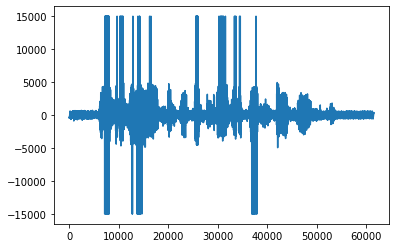

In [78]:
#!!!!!!! Distortion !!!!!!!
#Задаем порог Th. Если сигнал меньше порога - оставляем как есть, если больше - приравниваем максимуму

Th = 5000#граница с которой начинать дисторт
Max = 15000#до какого уровня доводить
DistortData = []#для хранения дисторта

for it in data:
    if it > Th:#если выше границы - усиляем
        DistortData.append(Max)
    elif it < -Th:#если ниже границы - усиляем
        DistortData.append(-Max)
    else:#оставляем как есть
        DistortData.append(it)

DistortData = np.asarray(DistortData, dtype=np.int16)#без этого преобразования не получится считать в файл
plt.plot(DistortData)
plt.show()

wavfile.write("DistortionMono16kHz.wav", freq, DistortData.astype(np.int16))#записали чтобы послушать